# Demo of `secop-ophyd` Integration 

This demo utilizes the samplechanger SEC node, and demonstrates the concurrent control and readout of EPICS Detectors and SECoP hardware.

prerequisites:
- a running instance ofURsim (see `/URsimDocker` directory) or the real UR3 robot samplechanger apparatus

- `remote mode`of the robot has to be enabled 
    
- a running SEC node for the samplechanger robot is needed as well:
    ```python3 frappy/bin/frappy-server -c frappy/cfg/UR_robot_cfg.py``` 


### Bluesky Runenegine Setup

In [1]:
from databroker.v2 import temp
from bluesky import RunEngine, Msg
import bluesky.plan_stubs as bps

import bluesky.preprocessors as bpp

from secop_ophyd.SECoPDevices import SECoP_Node_Device, SECoPReadableDevice, SECoPMoveableDevice, SECoP_CMD_Device

import random

from ophyd.sim import  SynGauss, motor

noisy_det0 = SynGauss(
        "noisy_det0",
        motor,
        "motor",
        center=1,
        Imax=1,
        noise="uniform",
        sigma=1,
        noise_multiplier=0.4,
        labels={"detectors"},
    )

noisy_det1 = SynGauss(
        "noisy_det1",
        motor,
        "motor",
        center=0.5,
        Imax=1,
        noise="uniform",
        sigma=1,
        noise_multiplier=1,
        labels={"detectors"},
    )

noisy_det2 = SynGauss(
        "noisy_det2",
        motor,
        "motor",
        center=0,
        Imax=1,
        noise="uniform",
        sigma=1,
        noise_multiplier=3,
        labels={"detectors"},
    )





# Create a run engine and a temporary file backed database. Send all the documents from the RE into that database
RE = RunEngine({})
db = temp()
RE.subscribe(db.v1.insert)





#Example of adding metadata to RE environment
investigation_id = "kmnk2n34"

RE.md["investigation_id"] = investigation_id



### SECoP-Ophyd Device generation

In [2]:


# Connect to SEC Node and generate ophyd device tree
robo_dev = await SECoP_Node_Device.create('localhost','10770',RE.loop)


#One Device for every Robot SECoP Module 
storage:SECoPReadableDevice= robo_dev.storage
sample:SECoPMoveableDevice= robo_dev.sample
robot:SECoPMoveableDevice= robo_dev.robot

#Devices for SECoP Commands
loadshort:SECoP_CMD_Device = storage.load_short_dev
measure:SECoP_CMD_Device = sample.measure_dev


sample_changer.HZB ready


/home/peter/git-repos/secop-ophyd/.venv/lib64/python3.11/site-packages/secop_ophyd/SECoPDevices.py:242: UserWarning: Arrays of composed datatypes are not supported. Array of tuples/structs is turned to Array of Strings
  warnings.warn(


### Populating the Storage Module

Samples of random substance are loaded into the storage module  

In [3]:



SCHOKO_SORTEN = {
    0:'Knusperkeks',
    1:'Edel-Vollmilch',
    2:'Knusperflakes',
    3:'Nuss-Splitter',
    4:'Nugat',
    5:'Marzipan',
    6:'Joghurt',
}



# Example Plan for loading samples into the robot
def load_samples(storage, lower, upper):
    loadshort:SECoP_CMD_Device = storage.load_short_dev

    for samplepos in range(lower,upper):
        
        ### populate Command arguments
        # set target sample position        
        yield from bps.abs_set(loadshort.samplepos_arg,samplepos, group='sample')
        
        # set substance of sample
        substance = random.randint(0,6)
        yield from bps.abs_set(loadshort.substance_arg,substance, group='sample')         


        ## wait for arguments to be set (should be instant because command args are locally saved dummy signals)
        yield from bps.wait('sample')
        

        # Trigger command execution of _load_short command
        yield from bps.trigger(loadshort,wait=True)        

        print( 'A \'' + SCHOKO_SORTEN[substance] + '\' sample has been loaded into position '+ str(samplepos) + '.')



## loading random samples
RE(load_samples(storage,1,4))
        

A 'Nugat' sample has been loaded into position 1.
A 'Nugat' sample has been loaded into position 2.
A 'Edel-Vollmilch' sample has been loaded into position 3.


()

### Making a Measurement (`_measure()` Command)

Here a simulated EPICS detector is read while the SECoP `_measure()` Command is running. 

In [4]:
def measure(sample,sample_num):

    ## Sample Check
    # check if robot is currently holding a sample and 
    # put it back into storage if its not th correct one    
    reading = yield from bps.read(sample)
  
    curr_sample = reading[sample.value.name]['value']
    
    # holding wrong sample -->  put it back into storage
    if curr_sample != 0 and curr_sample  != sample_num :
        yield from bps.mv(sample,0)
    
    # gripper empty --> grab correct sample
    if curr_sample == 0:
        print('grabbing sample: '+str(i))
        yield from bps.mv(sample,i)
    
    print('holding sample: '+str(i))
    
    @bpp.run_decorator()
    def inner_meas(sample):
        
          
        complete_status = yield from bps.trigger(sample.measure_dev, wait=False) #This message doesn't exist yet
        print('starting measurement')
        
        # While the device is still executing, read from the detectors in the detectors list
        while not complete_status.done:

            yield Msg('checkpoint') # allows us to pause the run 
            
            yield from bps.one_shot([noisy_det0,noisy_det1,noisy_det2]) #triggers and reads everything in the detectors list
           
           
            yield Msg('sleep', None, 1)       
        
        print('measurement done')
            
      
    ### Do actual measurement ###
    uid = yield from inner_meas(sample)

 
    # put sample back into storage
    print('putting back sample: '+str(i))
    yield from  bps.mv(sample,0)

    return uid




for i in range(1,4):
    #grab sample i and hold in Measurement Pos
    RE(measure(sample,i))
    


grabbing sample: 1
holding sample: 1
starting measurement
measurement done
putting back sample: 1
grabbing sample: 2
holding sample: 2
starting measurement
measurement done
putting back sample: 2
grabbing sample: 3
holding sample: 3
starting measurement
measurement done
putting back sample: 3


### Plotting Detector data for the most recent Sample

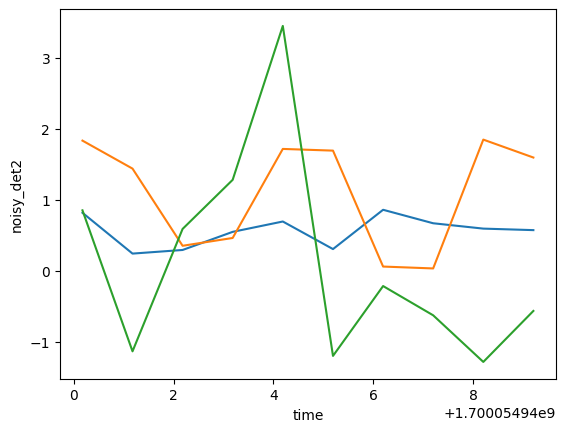

In [5]:

run=db[-1]
data = run.primary.read()
data["noisy_det0"].plot()
data["noisy_det1"].plot()
data["noisy_det2"].plot()
